In [1]:

import pandas as pd
import json
from tqdm import tqdm
import sys
sys.path.append('../src')  # Adjust the path accordingly if your structure is different

from utils import *


# Define global variables for file paths
DATA_PATH = '../data/data-2'
DATASET_CSV_PATH = '../data/data-1/dataset.csv'
COMBINED_DATASET_CSV_PATH = '../data/data-1/combined_dataset_06_03_24.csv'
ES_DEVICE_CVE_JSON_PATH = '../data/data-1/es_device_cve_description.json'
GPS_DEVICE_CVE_JSON_PATH = '../data/data-1/gps_device_cve_description.json'
ES_CVES_UNIQUE_JSON_PATH = '../data/data-1/es_cves_uniq_26_02_24.json'
GPS_CVES_UNIQUE_JSON_PATH = '../data/data-1/gps_cves_uniq_26_02_24.json'
ES_KEY_CVE_DISTRIBUTION_CSV_PATH = '../data/data-1/es_keywords_cve_counts_02_03_24.csv'
GPS_KEY_CVE_DISTRIBUTION_CSV_PATH = '../data/data-1/gps_keywords_cve_counts_02_03_24.csv'
ES_AUGMENTED_DATA_1_JSON_PATH = '../data/data-2/augmented_data_1_20.json'
ES_AUGMENTED_DATA_2_JSON_PATH = "../data/data-2/augmented_data_21_50.json"

# Loading the data
dataset = load_csv_data(DATASET_CSV_PATH)
df = load_csv_data(COMBINED_DATASET_CSV_PATH)
es_device_cve_description = load_json_data(ES_DEVICE_CVE_JSON_PATH)
gps_device_cve_description = load_json_data(GPS_DEVICE_CVE_JSON_PATH)
es_cves_unique = load_json_data(ES_CVES_UNIQUE_JSON_PATH)
gps_cves_unique = load_json_data(GPS_CVES_UNIQUE_JSON_PATH)
es_key_cve_distribution = load_csv_data(ES_KEY_CVE_DISTRIBUTION_CSV_PATH)
gps_key_cve_distribution = load_csv_data(GPS_KEY_CVE_DISTRIBUTION_CSV_PATH)
es_augmented_data_1 = load_json_data(ES_AUGMENTED_DATA_1_JSON_PATH)
es_augmented_data_2 = load_json_data(ES_AUGMENTED_DATA_2_JSON_PATH)


In [3]:
print("ES and GPS CVEs count Before cleaning intersections")
print(f"    Number of ES CVEs: {get_num_cves(es_cves_unique)}")
print(f"    Number of GPS CVEs: {get_num_cves(gps_cves_unique)}")

# Remove intersection CVEs between ES and GPS
es_cves_unique, gps_cves_unique = find_intersection_and_clean_data(ES_CVES_UNIQUE_JSON_PATH, GPS_CVES_UNIQUE_JSON_PATH, DATA_PATH)

print("ES and GPS CVEs count after cleaning intersections")
print(f"    Number of ES CVEs: {get_num_cves(es_cves_unique)}")
print(f"    Number of GPS CVEs: {get_num_cves(gps_cves_unique)}")

ES and GPS CVEs count Before cleaning intersections
    Number of ES CVEs: 13515
    Number of GPS CVEs: 32387
ES and GPS CVEs count after cleaning intersections
    Number of ES CVEs: 13515
    Number of GPS CVEs: 32387


In [68]:
# Create a dataframe with two columns: 'description' and 'label'.
# add 200 descriptions for each keyword. those with descriptions less than 200 add all of them
# those with more than 200 descriptions, add 200 random descriptions
# create a new dataframe to save new dataset to
import pandas as pd
from tqdm import tqdm

# Initialize the DataFrame only once, outside of the function
new_dataset = pd.DataFrame(columns=['description', 'label'])

def preprocess_description(description):
    # Remove all double quotes
    description = description.replace('"', '')
    # Remove all empty lines
    description = ' '.join([line for line in description.splitlines() if line.strip()])
    # Enclose in double quotes if not already enclosed
    #if not (description.startswith('"') and description.endswith('"')):
    #    description = f'"{description}"'
    return description

def add_cve_descriptions_to_dataset(key_to_cve, cve_to_desc, label):
    global new_dataset  # Declare the use of the global variable
    temp_data = []  # Initialize a temporary list to store the data
    
    for keyword in tqdm(key_to_cve.keys()):
        cves = key_to_cve[keyword]['cves']['id']
        if len(cves) > 200:
            cves = cves[:200]  # Limit the number of CVEs to 200 if there are more than 200

        for cve in cves:
            description = cve_to_desc[keyword].get(cve, "")
            if description:  # Ensure that the description exists before appending
                # Preprocess the description
                description = preprocess_description(description)
                temp_data.append({'description': description, 'label': label})
    
    # Convert the temp_data list to a DataFrame and append it to the new_dataset
    temp_df = pd.DataFrame(temp_data)
    new_dataset = pd.concat([new_dataset, temp_df], ignore_index=True)

# Example usage:
add_cve_descriptions_to_dataset(es_cves_unique, es_device_cve_description, 'es')
add_cve_descriptions_to_dataset(gps_cves_unique, gps_device_cve_description, 'gps')

# Save the new_dataset to a CSV file
new_dataset.to_csv('../dataset/underSampled_data_not_balanced.csv', index=False)
# print(new_dataset.head())





100%|██████████| 188/188 [00:00<00:00, 9710.71it/s]


100%|██████████| 108/108 [00:00<00:00, 2837.18it/s]


In [33]:
# Display the first few rows of the dataset
print(df.head())

# Get a summary of the dataset
print(df.describe())

# Check for missing values
print(df.isnull().sum())


                                         description label
0  A memory corruption issue was addressed with i...   esv
1  An out-of-bounds read was addressed with impro...   esv
2  An uncontrolled resource consumption vulnerabi...   esv
3  The XMPP server in Logitech Harmony Hub before...   esv
4  This issue was addressed with a new entitlemen...   esv
                                              description  label
count                                               70461  70461
unique                                              70461      2
top     A memory corruption issue was addressed with i...    esv
freq                                                    1  39250
description    0
label          0
dtype: int64


In [36]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Example of a simple text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    #text = re.sub(r'[^a-z\s]', '', text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Stemming
    #stemmer = PorterStemmer()
    #text = ' '.join(stemmer.stem(word) for word in text.split())
    
    return text

# Apply the cleaning function to your text column
# Replace 'text_column' with the name of your text column
df['cleaned_text'] = df['description'].apply(clean_text)


[(':', 70318), ('-', 52716), ('*', 47388), ('/', 33098), ('via', 30794), ('allows', 30194), ('vulnerability', 27813), ('remote', 26061), ('attackers', 25391), ('(', 22912)]


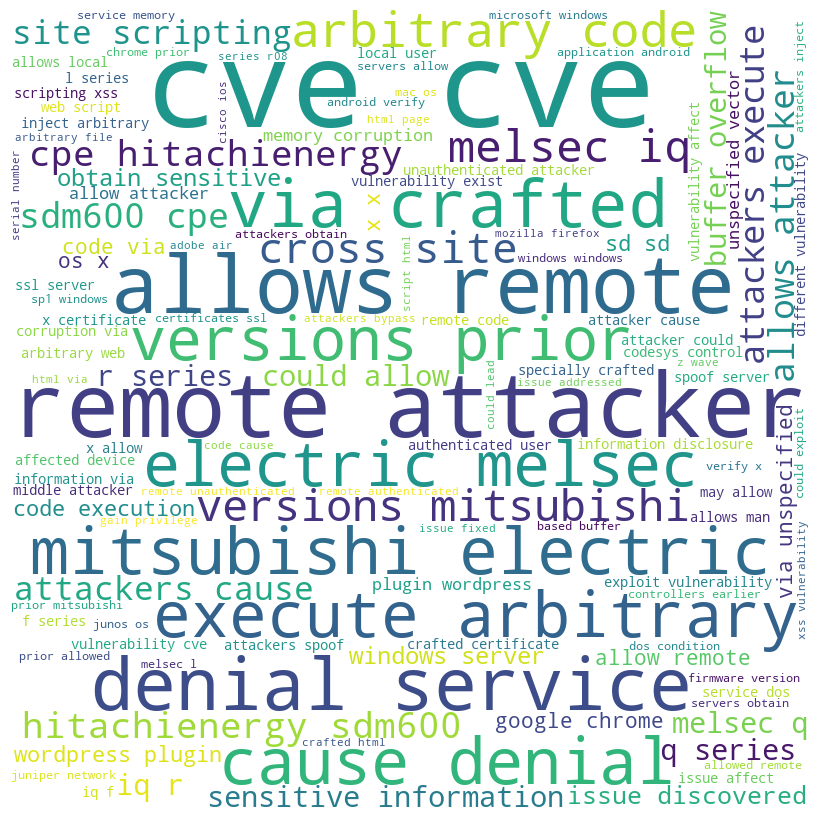

In [37]:
from collections import Counter

# Word frequency analysis
all_words = ' '.join(df['cleaned_text']).split()
word_counts = Counter(all_words)

# Most common words
print(word_counts.most_common(10))

# You can also use libraries like WordCloud to visualize word frequencies
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = set(stopwords.words('english')), 
                min_font_size = 10).generate(' '.join(all_words))

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=100)  # You can adjust max_features based on your dataset size
X = tfidf.fit_transform(df['cleaned_text']).toarray()


In [39]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)


In [43]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['numeric_label'] = label_encoder.fit_transform(df['label'])


In [48]:
df.numeric_label.value_counts()

numeric_label
0    39250
1    31211
Name: count, dtype: int64

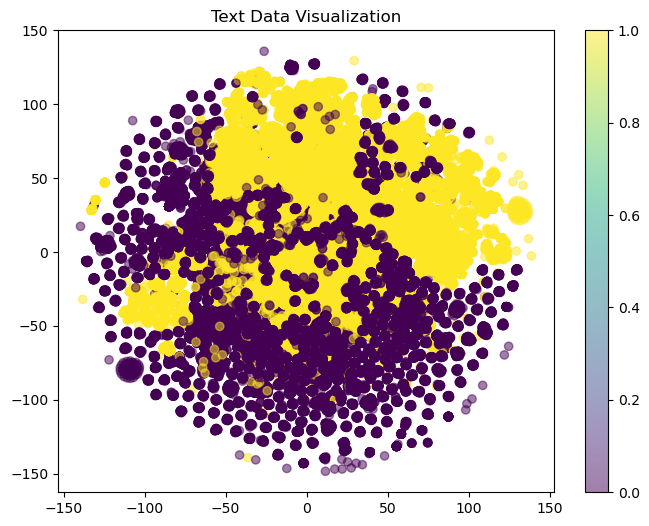

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df['numeric_label'], cmap='viridis', alpha=0.5)
plt.title('Text Data Visualization')
plt.colorbar(scatter)
# Save the figure
plt.savefig('../dataset/text_data_visualization.png', dpi=300)  # Adjust dpi for resolution
plt.show()


In [46]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 820.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 935.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [47]:
import gensim.downloader as api

word2vec_model = api.load('word2vec-google-news-300')  # This will download a pre-trained model

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [49]:
import numpy as np

# Define a function to convert documents to vectors
def document_to_vector(doc):
    words = doc.split()
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
    if len(word_vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Apply the function to each document
vectors = np.array([document_to_vector(doc) for doc in df['cleaned_text']])


In [52]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=3, random_state=42)
X_2d = tsne_model.fit_transform(vectors)

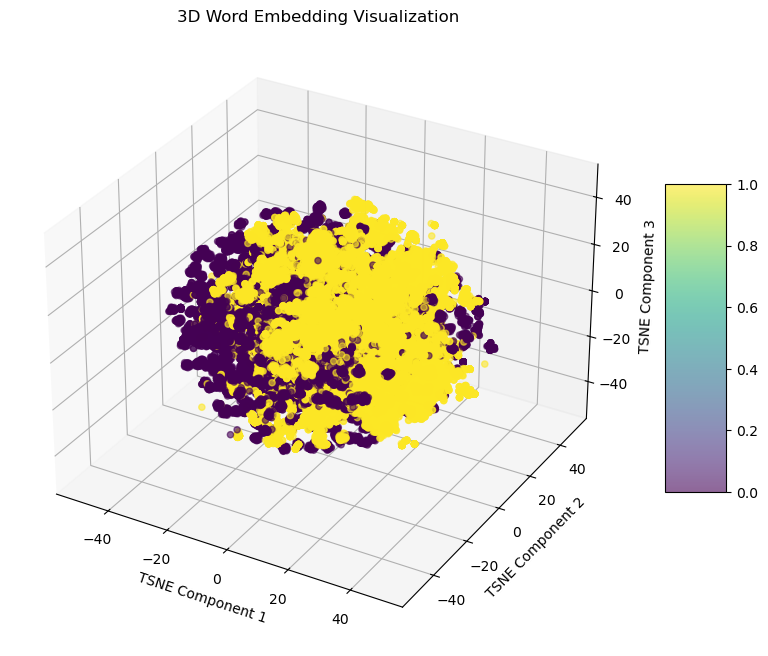

In [53]:
import matplotlib.pyplot as plt

# Now let's plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_2d[:, 0], X_2d[:, 1], X_2d[:, 2], c=df['numeric_label'], cmap='viridis', alpha=0.6)

# Title and labels
ax.set_title('3D Word Embedding Visualization')
ax.set_xlabel('TSNE Component 1')
ax.set_ylabel('TSNE Component 2')
ax.set_zlabel('TSNE Component 3')

# Color bar
cbar = plt.colorbar(scatter, shrink=0.5, aspect=5) # adding a color bar

# Show plot
plt.show()


In [22]:
import pandas as pd

# Load the dataset and augmented data
dataset = pd.read_csv('../data/dataset.csv')
augmented_data = load_json_data('../dataset/augmented_data_uniq.json')

# Extract the descriptions from the augmented data and create a new DataFrame
descriptions = []
for key in augmented_data.keys():
    for desc in augmented_data[key]:
        descriptions.append(desc[0])

labels = ['esv'] * len(descriptions)
augmented_df = pd.DataFrame({'description': descriptions, 'label': labels})

# Concatenate the two DataFrames to create a single DataFrame
combined_df = pd.concat([dataset, augmented_df], ignore_index=True)


In [23]:
combined_df.label.value_counts()

label
esv     39250
gpsv    31211
Name: count, dtype: int64

In [24]:
combined_df.to_csv('../data/combined_dataset_06_03_24.csv', index=False)

In [17]:
es_sum = 0
for key in es_cves_unique:
    es_sum += len(es_cves_unique[key]['cves']['id'])

print(es_sum)

gps_sum = 0
for key in gps_cves_unique:
    gps_sum += len(gps_cves_unique[key]['cves']['id'])

print(gps_sum)

13515
32387


In [4]:
# count number of descriptors for each CVE
sum = 0
for key in augmented_data:
    sum += len(augmented_data[key])
print(sum)

26250


In [6]:

# Removing duplicates from augmented data
for key in augmented_data:
    # Convert each list to a tuple so it can be added to a set (lists are not hashable)
    augmented_data[key] = [list(item) for item in set(tuple(sublist) for sublist in augmented_data[key])]

   

In [7]:
# count number of descriptors for each CVE
sum = 0
for key in augmented_data:
    sum += len(augmented_data[key])
print(sum)

26236


In [8]:
def dump_dict_to_json(data, file_path):
    """
    Dump a dictionary to a JSON file.

    :param data: The dictionary to be dumped.
    :param file_path: The path of the JSON file where the dictionary will be stored.
    """
    with open(file_path, 'w+') as json_file:
        json.dump(data, json_file, indent=4)

dump_dict_to_json(augmented_data, '/home/revo302/repos/nlpaug/dataset/augmented_data_uniq.json')

In [15]:
len(augmented_data['Zyxel Multy'])

50

In [3]:
from multiprocessing import Process, Lock


def f(l, i, text, aug):
    l.acquire()
    try:
        augmented_text = aug.augment(text)
        print(f"Process {i} augmented text: {augmented_text}")
    finally:
        l.release()

if __name__ == '__main__':
    lock = Lock()
    text = "The quick brown fox jumps over the lazy dog"
    aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="insert")
    for num in range(2):
        Process(target=f, args=(lock, num, text, aug)).start()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/revo/anaconda3/envs/ai/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/revo/anaconda3/envs/ai/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'f' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/revo/anaconda3/envs/ai/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/revo/anaconda3/envs/ai/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^